# セットアップ
プロットのスタイルもここで指定

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "MS Gothic"

from xlrd.formatting import Font # 使ってないかも？
import pandas as pd
import pandas_datareader.data as web
import datetime as dt
import math

# 数値シミュレーション
## データ生成
各銘柄のリターンについて，適当な事前分布から確率分布を生成．事前分布は`Normal-Wishart`分布を用いる．
https://kazufusa1484.hatenablog.com/entry/2018/07/27/121549

In [2]:
n_stocks = 30 # 銘柄数
nu_wishart = 70 # Wishart分布の自由度，大きいほど分散行列は小さくなる
mu0 = 0.02 # リターンの期待値はこれくらいで
lambda0 = 40.0 # リターンの期待値をスケールする，大きいほどリターンは小さくなる
Lambda_wishart = stats.wishart.rvs(df = nu_wishart, scale = np.eye(n_stocks))
Sigma = np.linalg.inv(Lambda_wishart)
mu = stats.multivariate_normal.rvs(mu0 * np.ones(n_stocks), (1.0/lambda0)*Sigma)

最適ポートフォリオ(マーケットポートフォリオ)とベータの理論値を算出する．

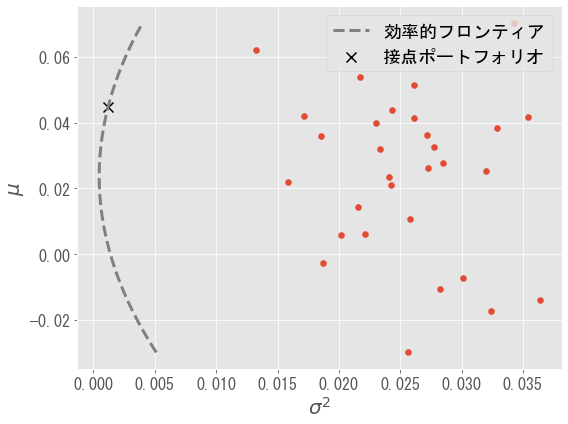

In [3]:
class CapitalAssetPricingModel:
    def __init__(self, mu, Sigma): # 各銘柄の期待リターンと共分散が入力
        self.mu, self.Sigma = mu, Sigma
        self.Lambda = np.linalg.inv(self.Sigma)
        self.A = self.Lambda.dot(self.mu).sum()
        self.B = self.mu.dot(self.Lambda).dot(self.mu)
        self.C = self.Lambda.sum()
        self.D = self.B*self.C - self.A*self.A
    
    def minimize_variance(self, mu_p, calc_weight = True): # 期待リターンの条件付きで，リスクを最小化
        sigma2 = (self.C*mu_p*mu_p - 2*self.A*mu_p + self.B) / self.D
        if calc_weight:
            weight = (mu_p * self.Lambda.dot(self.C*self.mu - self.A) + self.Lambda.dot(self.B - self.A*self.mu) ) / self.D
            return weight, sigma2
        else:
            return sigma2
    
    def draw_tangent(self, r_f): # 接点ポートフォリオを計算
        self.r_M = (self.B - self.A * r_f) / (self.A - self.C * r_f) # 接点ポートフォリオ
        self.weight_M, self.sigma2_M = self.minimize_variance(self.r_M)
        self.beta_M = self.Sigma.dot(self.weight_M) / (self.weight_M.dot(self.Sigma).dot(self.weight_M))

r_f = 0.01 # リスクフリーレート
model_market = CapitalAssetPricingModel(mu, Sigma)
model_market.draw_tangent(r_f)
mu_mesh = np.linspace(mu.min(), max(mu.max(), model_market.r_M), 100)
sigma_mesh = model_market.minimize_variance(mu_mesh, calc_weight = False)

# グラフの設定
fig = plt.figure(figsize = (8, 6), tight_layout = True)
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel(r"$\sigma^2$", size = 20)
ax.set_ylabel(r"$\mu$", size = 20)
ax.tick_params(labelsize = 16) # 目盛ラベルのサイズ
ax.scatter(np.diag(Sigma), mu)
ax.scatter(model_market.sigma2_M, model_market.r_M, marker="x", s=100, c = "black", label = "接点ポートフォリオ")
ax.plot(sigma_mesh, mu_mesh, color = "grey", linestyle = "--", linewidth = 3.0, label = "効率的フロンティア")

ax.legend(prop = {"family": "MS Gothic", "size": 18}) # 凡例に日本語を使うため

リターンのデータを作成

In [4]:
N = 60 # 60カ月のデータをもとに算出
Y = stats.multivariate_normal.rvs(mean = mu, cov = Sigma, size = N) # 各銘柄のリターン
X = Y.dot(model_market.weight_M) # マーケットポートフォリオのリターン

def add_const(X):
    return np.vstack((np.ones(len(X)), X)).T # 定数項を追加
X = add_const(X)
print(X.shape, Y.shape)

(60, 2) (60, 30)


## ナイーブな推計モデル

In [5]:
class LinearRegressionBeta:
    def __init__(self, lambda_ridge = 0.0):
        self.lambda_ridge = lambda_ridge
        
    def fit(self, Y, X): # Yは(N, n_stocks)
        N, n_factors = len(X), len(X[0])
        self.Y = Y.copy()
        self.X = X.copy()
        Lambda_ridge = self.lambda_ridge*np.eye(n_factors)

        self.W = np.linalg.inv(self.X.T.dot(self.X) + Lambda_ridge).dot(self.X.T).dot(self.Y)
        self.Y_pred = self.X.dot(self.W)
        self.sigma2 = ((self.Y_pred - self.Y) ** 2.0).sum(axis = 0) / (N - n_factors) # 標準誤差(の2乗)
        self.cov_beta = np.linalg.inv(self.X.T.dot(self.X) + Lambda_ridge) * self.sigma2.reshape(-1, 1, 1)
        self.var_beta = (self.cov_beta * np.eye(n_factors)).sum(axis = 1).T # Wと同じ形でbetaの分散

model_LR_beta = LinearRegressionBeta()
model_LR_beta.fit(Y, X)
beta_naive_list = model_LR_beta.W[-1:][0] # 多次元配列になっているため[0]で次元を落とす
std_beta_naive_list = np.sqrt(model_LR_beta.var_beta[-1:][0])
adjusted_beta = beta_naive_list * 2/3 + 1/3

No handles with labels found to put in legend.
No handles with labels found to put in legend.


naive:  0.6291835827360316
adjusted:  0.4339772432571636


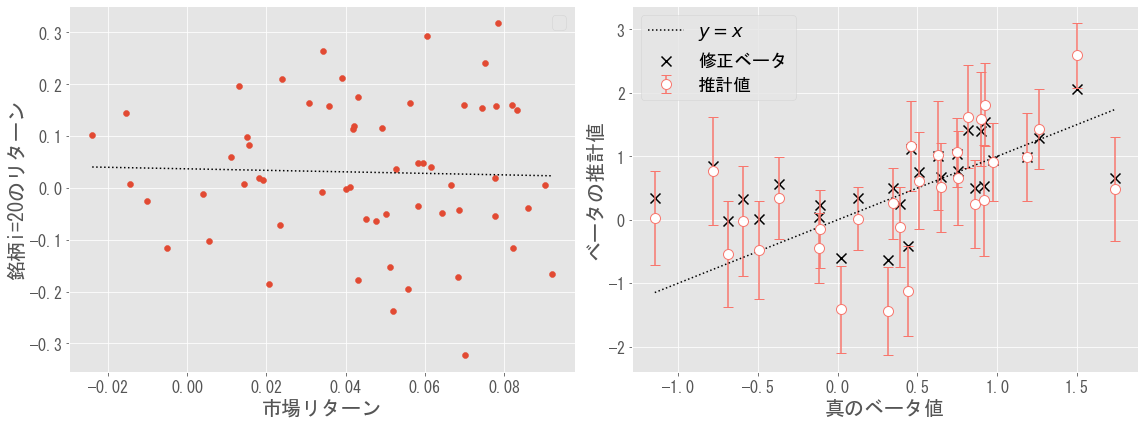

In [6]:
# 個別銘柄の推計
idx = 20
x_pred_idx = np.linspace(X[:, 1].min(), X[:, 1].max(), 100) # マーケットポートフォリオの範囲
X_pred_idx = np.vstack((np.ones(len(x_pred_idx)), x_pred_idx)).T # 定数項を追加
y_pred_idx = model_LR_beta.W[:, idx].dot(X_pred_idx.T)

# プロット
fig = plt.figure(figsize = (16, 6), tight_layout = True)
ax = fig.add_subplot(1, 2, 1)
ax.set_xlabel("市場リターン", size = 20, fontname = "MS Gothic")
ax.set_ylabel("銘柄i={:}のリターン".format(idx), size = 20, fontname = "MS Gothic")
ax.tick_params(labelsize = 16) # 目盛ラベルのサイズ
ax.legend(prop = {"family": "MS Gothic", "size": 18}) # 凡例に日本語を使うため
plt.scatter(X[:, 1], Y[:, idx])
plt.plot(x_pred_idx, y_pred_idx, "k:", label = "線形回帰")

ax = fig.add_subplot(1, 2, 2)
ax.set_xlabel("真のベータ値", size = 20, fontname = "MS Gothic")
ax.set_ylabel("ベータの推計値", size = 20, fontname = "MS Gothic")
ax.tick_params(labelsize = 16) # 目盛ラベルのサイズ
ax.legend(prop = {"family": "MS Gothic", "size": 18}) # 凡例に日本語を使うため

# 横軸に真のベータ値，縦軸にベータの推計値
mesh_plot = np.linspace(model_market.beta_M.min(), model_market.beta_M.max(), 100)
red_ggplot = "#F8766D"

print("naive: ", ((model_market.beta_M - beta_naive_list)**2.0).mean())
print("adjusted: ", ((model_market.beta_M - adjusted_beta)**2.0).mean())
plt.errorbar(model_market.beta_M, beta_naive_list, yerr = std_beta_naive_list, capsize = 5, fmt='o', \
    markersize=10, ecolor=red_ggplot, markeredgecolor = red_ggplot, color='w', label = "推計値")
plt.scatter(model_market.beta_M, adjusted_beta, marker="x", s=100, c = "black", label = "修正ベータ")
plt.plot(mesh_plot, mesh_plot, "k:", label = "$y=x$")
ax.legend(prop = {"family": "MS Gothic", "size": 18}) # 凡例に日本語を使うため

修正ベータに用いる仮定がどの程度正しいかを確認する．

In [7]:
print("mean of beta:", model_market.beta_M.mean())
print("variance of prior dist.: ", model_market.beta_M.var())
print("variance of beta for each company: ", std_beta_naive_list**2.0)

mean of beta: 0.4055313673419168
variance of prior dist.:  0.4783696040470062
variance of beta for each company:  [0.40056251 0.65112383 0.39762761 0.72545683 0.48354215 0.49763532
 0.29424388 0.37713331 0.48258243 0.30999068 0.60028945 0.48047515
 0.54993139 0.54633859 0.24427376 0.7566747  0.30475528 0.73399478
 0.41231435 0.67364411 0.3868729  0.42921528 0.48550316 0.47409018
 0.5485347  0.69600917 0.58325592 0.25902838 0.51220955 0.76404819]


## Bayes修正モデル

In [8]:
class BayesLinearRegressionBeta:
    def __init__(self, mu, Lambda, alpha): # Yは(N, n_stocks)
        self.mu, self.Lambda, self.alpha = mu, Lambda, alpha

    # 入力サイズで結果が不安定にならないように，全体を値を(N*n_stocks)でスケールしている
    def evidence(self, mu, Lambda, alpha):
        evidence_value = (0.5/self.N) * np.log(np.linalg.det(Lambda))
        evidence_value += -(0.5/self.N) * mu.dot(Lambda).dot(mu)
        evidence_value += 0.5*np.log(alpha).mean()

        A = [[] for _ in range(self.n_stocks)]
        z_vec = [[] for _ in range(self.n_stocks)]

        for i in range(self.n_stocks):
            y_i = self.Y[:, i]
            A[i] = Lambda + alpha[i] * self.X.T.dot(self.X)
            z_vec[i] = Lambda.dot(mu) + alpha[i] * self.X.T.dot(y_i)
            evidence_value += -0.5*np.log(np.linalg.det(A[i])) / (self.n_stocks*self.N)
            evidence_value += 0.5*z_vec[i].dot(np.linalg.inv(A[i])).dot(z_vec[i]) / (self.n_stocks*self.N)
            evidence_value += -0.5*alpha[i]*y_i.dot(y_i) / (self.n_stocks*self.N)
        return evidence_value

    def fit(self, Y, X, eta = 0.01, epsilon = 0.001, T = 100):
        self.X, self.Y = X.copy(), Y.copy()
        self.N, self.n_factors, self.n_stocks = len(X), len(X[0]), len(Y[0])
        self.eta = eta
        self.evidence_list = [[] for _ in range(T)]

        for t in range(T):
            # エビデンスを計算→格納
            self.evidence_t = self.evidence(self.mu, self.Lambda, self.alpha)
            self.evidence_list[t] = self.evidence_t
            print(t, self.evidence_t, end = "\n")

            if math.isnan(self.evidence_t):
                print("!!!ERROR!!!")
                break
        
            self.update_mu(epsilon)
            self.update_alpha(epsilon)
            self.update_Lambda(epsilon)
    
    def estimate(self):
        self.var_beta = np.zeros((self.n_factors, self.n_stocks))
        self.W = np.zeros((self.n_factors, self.n_stocks))

        for i in range(self.n_stocks):
            y_i = self.Y[:, i]
            A_i = self.Lambda + self.alpha[i] * self.X.T.dot(self.X)
            z_vec_i = self.Lambda.dot(self.mu) + self.alpha[i] * self.X.T.dot(y_i)
            self.W[:, i] = np.linalg.inv(A_i).dot(z_vec_i)
            self.var_beta[:, i] = np.linalg.inv(A_i).diagonal()

    def update_mu(self, epsilon):
        grad = np.zeros(self.n_factors)

        for i in range(self.n_factors):
            mu_new = self.mu.copy()
            mu_new[i] += epsilon
            evidence_t_new = self.evidence(mu_new, self.Lambda, self.alpha)
            grad[i] = (evidence_t_new - self.evidence_t) / epsilon
        self.mu += self.eta * grad

    def update_alpha(self, epsilon):
        grad = np.zeros(self.n_stocks)

        for i in range(self.n_factors):
            alpha_new = self.alpha.copy()
            alpha_new[i] += epsilon
            evidence_t_new = self.evidence(self.mu, self.Lambda, alpha_new)
            grad[i] = (evidence_t_new - self.evidence_t) / epsilon
        self.alpha += self.eta * grad

    def update_Lambda(self, epsilon):
        grad = np.zeros((self.n_factors, self.n_factors))
        for i in range(self.n_factors):
            for j in range(self.n_factors):
                Lambda_new = self.Lambda.copy()
                Lambda_new[i, j] += epsilon
                Lambda_new[j, i] += epsilon
                evidence_t_new = self.evidence(self.mu, Lambda_new, self.alpha)
                grad[i, j] = (evidence_t_new - self.evidence_t) / epsilon
        self.Lambda += self.eta * grad

mu_initial = model_LR_beta.W.mean(axis = 1)
Lambda_initial = np.linalg.inv(np.cov(model_LR_beta.W))
alpha_initial = 1.0 / model_LR_beta.sigma2

model_bayes = BayesLinearRegressionBeta(mu_initial, Lambda_initial, alpha_initial)
model_bayes.fit(Y, X)
model_bayes.estimate()


0 1.3538035145914011
1 1.3538041492824722
2 1.3538046657798735
3 1.3538050901856578
4 1.353805442337253
5 1.3538057374098156
6 1.3538059870907617
7 1.3538062004437665
8 1.3538063845468888
9 1.353806544965927
10 1.3538066861073037
11 1.353806811482504
12 1.353806923907406
13 1.3538070256534236
14 1.353807118562878
15 1.3538072041376368
16 1.3538072836076904
17 1.3538073579845833
18 1.3538074281033228
19 1.3538074946554837
20 1.3538075582155313
21 1.3538076192618875
22 1.3538076781938844
23 1.3538077353454963
24 1.35380779099651
25 1.3538078453816593
26 1.3538078986981334
27 1.353807951111759
28 1.353808002762119
29 1.3538080537667967
30 1.353808104224914
31 1.353808154220079
32 1.3538082038228447
33 1.3538082530927738
34 1.353808302080175
35 1.3538083508275431
36 1.3538083993707897
37 1.3538084477402674
38 1.3538084959616357
39 1.3538085440565868
40 1.3538085920434655
41 1.3538086399377884
42 1.3538086877526767
43 1.3538087354992294
44 1.3538087831868368
45 1.353808830823442
46 1.353808

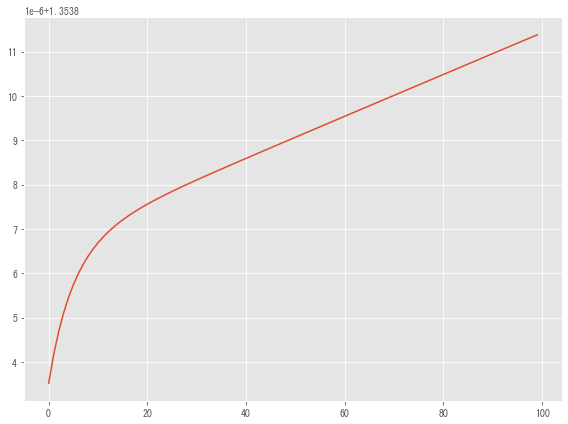

In [9]:
fig = plt.figure(figsize = (8, 6), tight_layout = True)
plt.plot(range(len(model_bayes.evidence_list)), model_bayes.evidence_list)

No handles with labels found to put in legend.


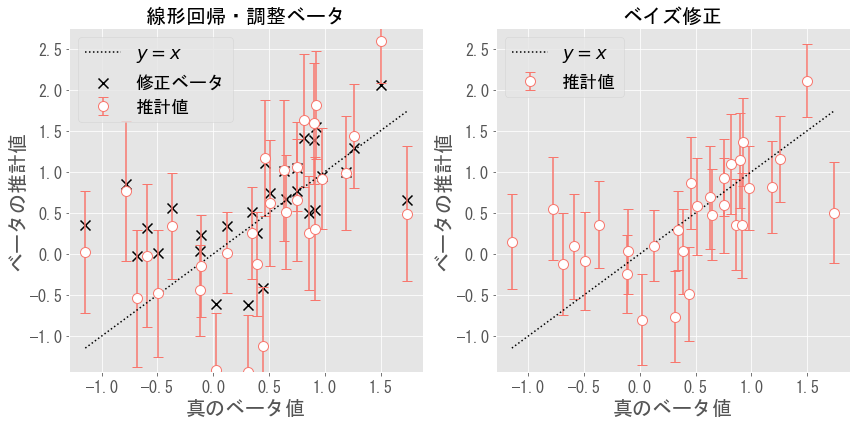

In [10]:
beta_bayes_list = model_bayes.W[1]
std_beta_bayes_list = np.sqrt(model_bayes.var_beta[1])
beta_est_min = min(beta_bayes_list) - max(std_beta_bayes_list)
beta_est_max = max(beta_bayes_list) + max(std_beta_bayes_list)

fig = plt.figure(figsize = (12, 6), tight_layout = True)
ax = fig.add_subplot(1, 2, 1)
ax.set_xlabel("真のベータ値", size = 20, fontname = "MS Gothic")
ax.set_ylabel("ベータの推計値", size = 20, fontname = "MS Gothic")
ax.tick_params(labelsize = 16) # 目盛ラベルのサイズ
ax.legend(prop = {"family": "MS Gothic", "size": 18}) # 凡例に日本語を使うため
ax.set_title("線形回帰・調整ベータ", fontname = "MS Gothic", size = 20)
ax.set_ylim(beta_est_min, beta_est_max)

# 横軸に真のベータ値，縦軸にベータの推計値
mesh_plot = np.linspace(model_market.beta_M.min(), model_market.beta_M.max(), 100)

plt.errorbar(model_market.beta_M, beta_naive_list, yerr = std_beta_naive_list, capsize = 5, fmt='o', \
    markersize=10, ecolor=red_ggplot, markeredgecolor = red_ggplot, color='w', label = "推計値")
plt.scatter(model_market.beta_M, adjusted_beta, marker="x", s=100, c = "black", label = "修正ベータ")
ax.plot(mesh_plot, mesh_plot, "k:", label = "$y=x$")
ax.legend(prop = {"family": "MS Gothic", "size": 18}) # 凡例に日本語を使うため

ax = fig.add_subplot(1, 2, 2)
ax.set_xlabel("真のベータ値", size = 20, fontname = "MS Gothic")
ax.set_ylabel("ベータの推計値", size = 20, fontname = "MS Gothic")
ax.tick_params(labelsize = 16) # 目盛ラベルのサイズ
ax.set_title("ベイズ修正", fontname = "MS Gothic", size = 20)
ax.set_ylim(beta_est_min, beta_est_max)
# 横軸に真のベータ値，縦軸にベータの推計値
mesh_plot = np.linspace(model_market.beta_M.min(), model_market.beta_M.max(), 100)
ax.errorbar(model_market.beta_M, beta_bayes_list, yerr = std_beta_bayes_list, capsize = 5, fmt='o', \
    markersize=10, ecolor=red_ggplot, markeredgecolor = red_ggplot, color="w", label = "推計値")
ax.plot(mesh_plot, mesh_plot, "k:", label = "$y=x$")
ax.legend(prop = {"family": "MS Gothic", "size": 18}) # 凡例に日本語を使うため

No handles with labels found to put in legend.


<BarContainer object of 3 artists>

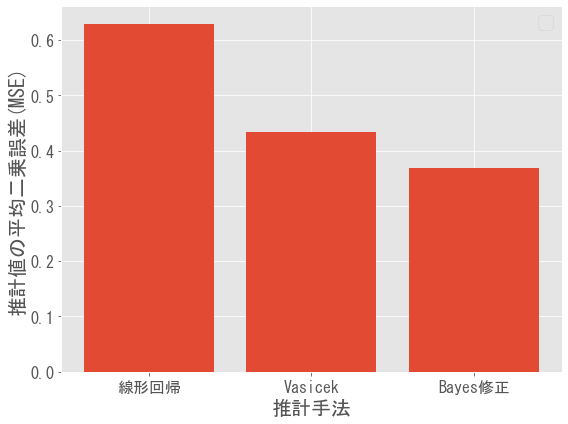

In [11]:
fig = plt.figure(figsize = (8, 6), tight_layout = True)
ax = fig.add_subplot(1, 1, 1)

labels = ['線形回帰', 'Vasicek', 'Bayes修正']
left = np.arange(1, len(labels)+1)
error_naive = ((model_market.beta_M - beta_naive_list)**2.0).mean()
error_adjusted = ((model_market.beta_M - adjusted_beta)**2.0).mean()
error_bayes = ((model_market.beta_M - beta_bayes_list)**2.0).mean()
errors = [error_naive, error_adjusted, error_bayes]

ax.set_xlabel("推計手法", size = 20, fontname = "MS Gothic")
ax.set_ylabel("推計値の平均二乗誤差(MSE)", size = 20, fontname = "MS Gothic")
ax.legend(prop = {"family": "MS Gothic", "size": 18}) # 凡例に日本語を使うため
ax.tick_params(labelsize = 16)
ax.bar(left, height = errors, tick_label = labels, align = "center")


# データ分析

## ユニバースの決定
簡単のため，対象はTOPIX CORE30構成企業とする．

In [12]:
# パラメータの設定
yyyy_mm_dd = "2022-10-30"
yyyymm = yyyy_mm_dd[0:7].replace("-", "")
print(yyyymm)

202210


In [13]:
# https://www.jpx.co.jp/markets/statistics-equities/misc/01.htmlから取得してdata_j_20221.xlsxと名前をつける
df_stock_code = pd.read_excel("data_j_20221.xlsx")
# topix_range_list = ["TOPIX Core30", "TOPIX Large70", "TOPIX Mid400"]
topix_range_list = ["TOPIX Core30", "TOPIX Large70"]
# topix_range_list = ["TOPIX Core30"]

df_universe = df_stock_code[df_stock_code["規模区分"].isin(topix_range_list)].copy()
df_universe["銘柄名"] = df_universe["銘柄名"].str.replace("フィナンシャルグループ", "ＦＧ")
df_universe["銘柄名"] = df_universe["銘柄名"].str.replace("フィナンシャル・グループ", "ＦＧ")
df_universe["銘柄名"] = df_universe["銘柄名"].str.replace("・ホールディングス", "ＨⅮ")
df_universe["銘柄名"] = df_universe["銘柄名"].str.replace("ホールディングス", "ＨⅮ")
df_universe["銘柄名"] = df_universe["銘柄名"].str.replace("グループ", "Ｇ")
df_universe["銘柄名"] = df_universe["銘柄名"].str.replace("グループ", "Ｇ")
df_universe.head(5) # 30社を取得することができている

,日付,コード,銘柄名,市場・商品区分,33業種コード,33業種区分,17業種コード,17業種区分,規模コード,規模区分
309,20221130,1925,大和ハウス工業,プライム（内国株式）,2050,建設業,3,建設・資材,2,TOPIX Large70
311,20221130,1928,積水ハウス,プライム（内国株式）,2050,建設業,3,建設・資材,2,TOPIX Large70
517,20221130,2413,エムスリー,プライム（内国株式）,9050,サービス業,10,情報通信・サービスその他,2,TOPIX Large70
562,20221130,2502,アサヒＧＨⅮ,プライム（内国株式）,3050,食料品,1,食品,2,TOPIX Large70
563,20221130,2503,キリンＨⅮ,プライム（内国株式）,3050,食料品,1,食品,2,TOPIX Large70


# データの取得
ユニバースについて，株価のデータを取得する．

In [14]:
df_stock_price = pd.DataFrame()

start = "2011-01-01" # ベータを計算するのに十分なくらい昔の，適当な日付を選択
end = yyyy_mm_dd
idx_stock = 0
is_load_pickle = False # 初めはFalseにしておく必要あり，二回目からはFalseでOK

if not is_load_pickle: # 読み込むため時間がかかる
    for code in df_universe["コード"].values:
        idx_stock += 1
        print("証券コード：" + str(code) + "を処理中．．．" + str(idx_stock) + "/" + str(len(df_universe["コード"])), end = "\r")
        code_yahoo = str(code) + ".T" # Yahoo Financeのシンボルに変換，東証の場合はこのようにする
        df_code = web.DataReader(code_yahoo, data_source = 'yahoo', start = start, end = end)
        df_code["Code"] = code
        df_stock_price = pd.concat([df_stock_price, df_code]).copy()

    # TOPIXの株価推移を取得
    df_topix = web.DataReader("^TPX", data_source = 'stooq', start = start, end = end)
    df_topix["Adj Close"] = df_topix["Close"].copy()
    df_topix["Code"] = "TOPIX"
    df_topix = df_topix.sort_values("Date").copy()
    df_stock_price = pd.concat([df_stock_price, df_topix]).copy()
    df_stock_price.to_pickle("df_stock_price.pkl")
else:
    df_stock_price = pd.read_pickle("df_stock_price.pkl")

In [15]:
num_month_train = 60 + 1
num_month_valid = 60 + 1 
df_stock_price = df_stock_price[["Code", "Close", "Adj Close"]].copy() # 修正済み株価(終値)をもとに算出
df_stock_price["YYYYMM"] = df_stock_price.index.strftime("%Y%m")
df_stock_price["Code-YYYYMM"] = df_stock_price["Code"].astype("str") + "-" + df_stock_price["YYYYMM"]
# 銘柄+年月で最も下の行のもの(月末)を選び，銘柄ごとに60か月分を抽出
df_stock_price_monthly = df_stock_price.groupby("Code-YYYYMM").tail(1).groupby("Code").tail(num_month_valid+num_month_valid)
print(df_stock_price_monthly)

             Code    Close    Adj Close  YYYYMM   Code-YYYYMM
Date                                                         
2012-09-28   1925  1133.00   846.949646  201209   1925-201209
2012-10-31   1925  1209.00   903.762024  201210   1925-201210
2012-11-30   1925  1260.00   941.885864  201211   1925-201211
2012-12-28   1925  1479.00  1105.594727  201212   1925-201212
2013-01-31   1925  1679.00  1255.100342  201301   1925-201301
...           ...      ...          ...     ...           ...
2022-06-30  TOPIX  1870.82  1870.820000  202206  TOPIX-202206
2022-07-29  TOPIX  1940.31  1940.310000  202207  TOPIX-202207
2022-08-31  TOPIX  1963.16  1963.160000  202208  TOPIX-202208
2022-09-30  TOPIX  1835.94  1835.940000  202209  TOPIX-202209
2022-10-28  TOPIX  1899.05  1899.050000  202210  TOPIX-202210

[12184 rows x 5 columns]


In [16]:
df_stock_pivot = df_stock_price_monthly.pivot_table("Adj Close", index = "YYYYMM", columns = ["Code"])
df_stock_pivot.dropna(axis = 1, inplace = True) # ソフトバンクは5年の株価が取れないため落ちる
# df_stock_pivot.drop(columns = 7846, inplace = True) # パイロットのデータはおかしいので削除
df_universe = df_universe[df_universe["コード"].isin(df_stock_pivot.columns)].copy()
df_stock_return = df_stock_pivot.pct_change().dropna() # 変化率を計算，一番初めはNaNになるため落とす
# valid
df_stock_return_valid = df_stock_return.tail(num_month_valid)
Y_valid = df_stock_return_valid.iloc[:, :-1].values
X_valid = df_stock_return_valid.iloc[:, -1].values
X_valid = add_const(X_valid) # 定数項を追加
# train
df_stock_return_train = df_stock_return.tail(num_month_train+num_month_valid).head(num_month_train)
Y_train = df_stock_return_train.iloc[:, :-1].values
X_train = df_stock_return_train.iloc[:, -1].values
X_train = add_const(X_train) # 定数項を追加

print(Y_train.shape, X_train.shape)
print(Y_valid.shape, X_valid.shape)

(61, 97) (61, 2)
(61, 97) (61, 2)


In [17]:
model_LR_beta = LinearRegressionBeta()
# train
model_LR_beta.fit(Y_train, X_train)
beta_naive_list_train = model_LR_beta.W[-1:][0] # 多次元配列になっているため[0]で次元を落とす
std_beta_naive_list_train = np.sqrt(model_LR_beta.var_beta[-1:][0])
adjusted_beta_train = beta_naive_list_train * 2/3 + 1/3
# valid
model_LR_beta.fit(Y_valid, X_valid)
beta_naive_list_valid = model_LR_beta.W[-1:][0] # 多次元配列になっているため[0]で次元を落とす

No handles with labels found to put in legend.
No handles with labels found to put in legend.


naive:  0.17522181340178156
adjusted:  0.12046536754437139


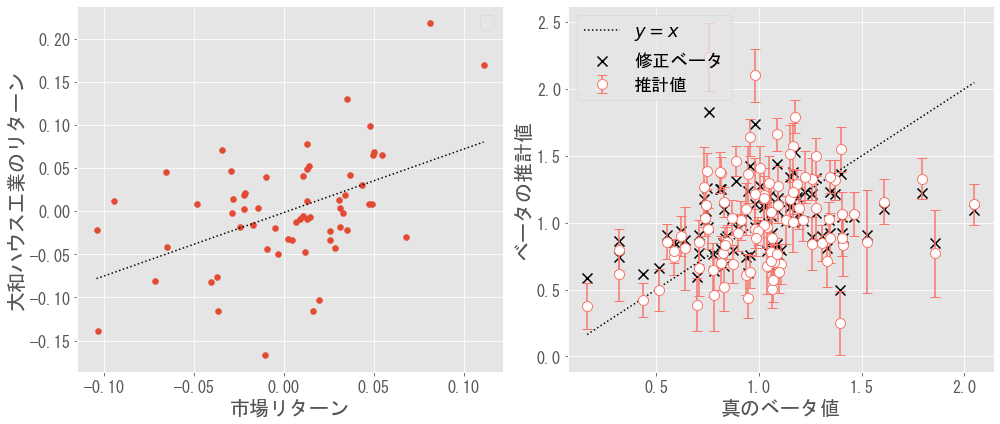

In [18]:
# 個別銘柄の推計
idx = 0
x_pred_idx = np.linspace(X_valid[:, 1].min(), X_valid[:, 1].max(), 100) # マーケットポートフォリオの範囲
X_pred_idx = add_const(x_pred_idx)
y_pred_idx = model_LR_beta.W[:, idx].dot(X_pred_idx.T)

# プロット
fig = plt.figure(figsize = (14, 6), tight_layout = True)
ax = fig.add_subplot(1, 2, 1)
ax.set_xlabel("市場リターン", size = 20, fontname = "MS Gothic")
ax.set_ylabel(df_universe.iloc[idx]["銘柄名"] + "のリターン", size = 20, fontname = "MS Gothic")
ax.tick_params(labelsize = 16) # 目盛ラベルのサイズ
ax.legend(prop = {"family": "MS Gothic", "size": 18}) # 凡例に日本語を使うため
plt.scatter(X_valid[:, 1], Y_valid[:, idx])
plt.plot(x_pred_idx, y_pred_idx, "k:", label = "線形回帰")

ax = fig.add_subplot(1, 2, 2)
ax.set_xlabel("真のベータ値", size = 20, fontname = "MS Gothic")
ax.set_ylabel("ベータの推計値", size = 20, fontname = "MS Gothic")
ax.tick_params(labelsize = 16) # 目盛ラベルのサイズ
ax.legend(prop = {"family": "MS Gothic", "size": 18}) # 凡例に日本語を使うため

# 横軸に真のベータ値，縦軸にベータの推計値
mesh_plot = np.linspace(beta_naive_list_valid.min(), beta_naive_list_valid.max(), 100)
red_ggplot = "#F8766D"

print("naive: ", ((beta_naive_list_valid - beta_naive_list_train)**2.0).mean())
print("adjusted: ", ((beta_naive_list_valid - adjusted_beta_train)**2.0).mean())
plt.errorbar(beta_naive_list_valid, beta_naive_list_train, yerr = std_beta_naive_list_train, capsize = 5, fmt='o', \
    markersize=10, ecolor=red_ggplot, markeredgecolor = red_ggplot, color='w', label = "推計値")
plt.scatter(beta_naive_list_valid, adjusted_beta_train, marker="x", s=100, c = "black", label = "修正ベータ")
plt.plot(mesh_plot, mesh_plot, "k:", label = "$y=x$")
ax.legend(prop = {"family": "MS Gothic", "size": 18}) # 凡例に日本語を使うため

In [19]:
model_LR_beta.fit(Y_train, X_train) # ハイパーパラメータの初期値もtrainから決める
mu_initial = model_LR_beta.W.mean(axis = 1)
Lambda_initial = np.linalg.inv(np.cov(model_LR_beta.W))
alpha_initial = 1.0 / model_LR_beta.sigma2

model_bayes = BayesLinearRegressionBeta(mu_initial, Lambda_initial, alpha_initial)
model_bayes.fit(Y_train, X_train, eta = 0.01, epsilon = 0.0001, T = 100)
model_bayes.estimate()

0 2.317930255104514
1 2.3179763539757956
2 2.3180003677452046
3 2.3180017806745843
4 2.3180052712322934
5 2.3180046323732144
6 2.318005350523207
7 2.3180050716076552
8 2.3180052571190357
9 2.3180051679405227
10 2.318005221192415
11 2.3180051951726477
12 2.3180052115988397
13 2.3180052048140296
14 2.318005210575035
15 2.3180052095095016
16 2.3180052121426047
17 2.318005212764665
18 2.318005214475644
19 2.3180052155932365
20 2.318005217030636
21 2.3180052182922144
22 2.3180052196469996
23 2.3180052209489803
24 2.3180052222774004
25 2.3180052235892608
26 2.3180052249079135
27 2.3180052262206727
28 2.318005227534441
29 2.3180052288454753
30 2.3180052301558036
31 2.3180052314643373
32 2.318005232771675
33 2.3180052340774866
34 2.318005235381965
35 2.3180052366850052
36 2.318005237986673
37 2.318005239286934
38 2.318005240585815
39 2.318005241883301
40 2.318005243179414
41 2.3180052444741355
42 2.3180052457674956
43 2.3180052470594616
44 2.3180052483500697
45 2.318005249639305
46 2.318005250

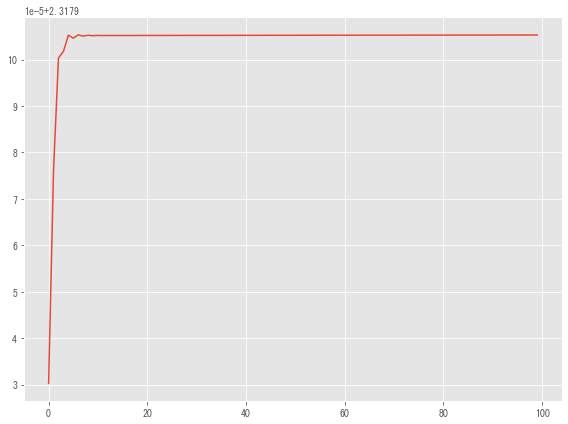

In [20]:
fig = plt.figure(figsize = (8, 6), tight_layout = True)
plt.plot(range(len(model_bayes.evidence_list)), model_bayes.evidence_list)

No handles with labels found to put in legend.


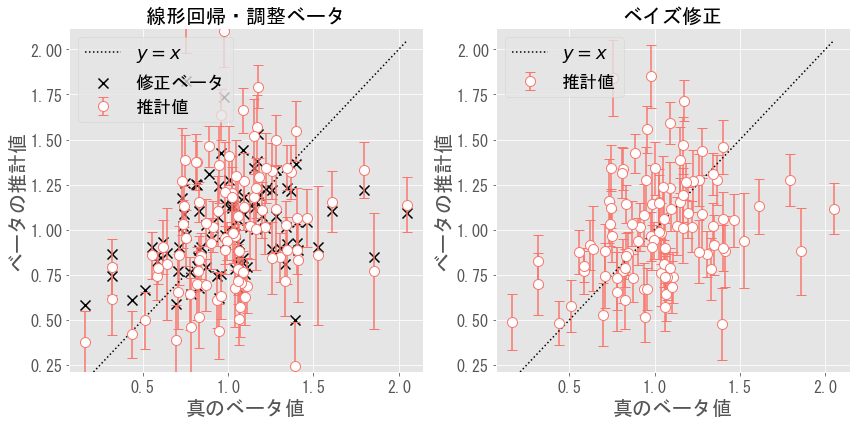

In [21]:
beta_bayes_list = model_bayes.W[1]
std_beta_bayes_list = np.sqrt(model_bayes.var_beta[1])
beta_est_min = min(beta_bayes_list) - max(std_beta_bayes_list)
beta_est_max = max(beta_bayes_list) + max(std_beta_bayes_list)

fig = plt.figure(figsize = (12, 6), tight_layout = True)
ax = fig.add_subplot(1, 2, 1)
ax.set_xlabel("真のベータ値", size = 20, fontname = "MS Gothic")
ax.set_ylabel("ベータの推計値", size = 20, fontname = "MS Gothic")
ax.tick_params(labelsize = 16) # 目盛ラベルのサイズ
ax.legend(prop = {"family": "MS Gothic", "size": 18}) # 凡例に日本語を使うため
ax.set_title("線形回帰・調整ベータ", fontname = "MS Gothic", size = 20)
ax.set_ylim(beta_est_min, beta_est_max)

# 横軸に真のベータ値，縦軸にベータの推計値
mesh_plot = np.linspace(beta_naive_list_valid.min(), beta_naive_list_valid.max(), 100)
plt.errorbar(beta_naive_list_valid, beta_naive_list_train, yerr = std_beta_naive_list_train, capsize = 5, fmt='o', \
    markersize=10, ecolor=red_ggplot, markeredgecolor = red_ggplot, color='w', label = "推計値")
plt.scatter(beta_naive_list_valid, adjusted_beta_train, marker="x", s=100, c = "black", label = "修正ベータ")
plt.plot(mesh_plot, mesh_plot, "k:", label = "$y=x$")
ax.legend(prop = {"family": "MS Gothic", "size": 18}) # 凡例に日本語を使うため

ax = fig.add_subplot(1, 2, 2)
ax.set_xlabel("真のベータ値", size = 20, fontname = "MS Gothic")
ax.set_ylabel("ベータの推計値", size = 20, fontname = "MS Gothic")
ax.tick_params(labelsize = 16) # 目盛ラベルのサイズ
ax.set_title("ベイズ修正", fontname = "MS Gothic", size = 20)
ax.set_ylim(beta_est_min, beta_est_max)
# 横軸に真のベータ値，縦軸にベータの推計値
mesh_plot = np.linspace(beta_naive_list_valid.min(), beta_naive_list_valid.max(), 100)
ax.errorbar(beta_naive_list_valid, beta_bayes_list, yerr = std_beta_bayes_list, capsize = 5, fmt='o', \
    markersize=10, ecolor=red_ggplot, markeredgecolor = red_ggplot, color="w", label = "推計値")
ax.plot(mesh_plot, mesh_plot, "k:", label = "$y=x$")
ax.legend(prop = {"family": "MS Gothic", "size": 18}) # 凡例に日本語を使うため

No handles with labels found to put in legend.


<BarContainer object of 3 artists>

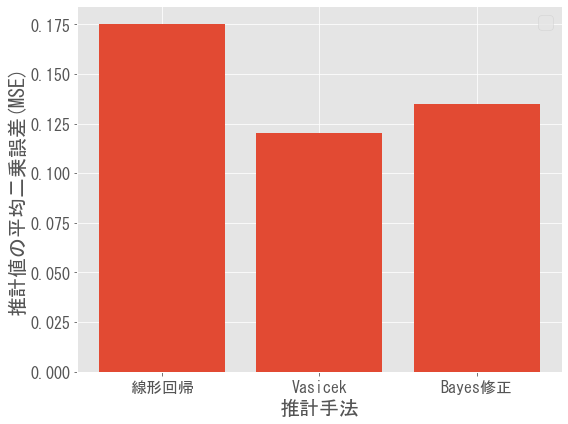

In [22]:
fig = plt.figure(figsize = (8, 6), tight_layout = True)
ax = fig.add_subplot(1, 1, 1)

labels = ['線形回帰', 'Vasicek', 'Bayes修正']
left = np.arange(1, len(labels)+1)
error_naive =  ((beta_naive_list_valid - beta_naive_list_train)**2.0).mean()
error_adjusted = ((beta_naive_list_valid - adjusted_beta_train)**2.0).mean()
error_bayes = ((beta_naive_list_valid - beta_bayes_list)**2.0).mean()
errors = [error_naive, error_adjusted, error_bayes]

ax.set_xlabel("推計手法", size = 20, fontname = "MS Gothic")
ax.set_ylabel("推計値の平均二乗誤差(MSE)", size = 20, fontname = "MS Gothic")
ax.legend(prop = {"family": "MS Gothic", "size": 18}) # 凡例に日本語を使うため
ax.tick_params(labelsize = 16)
ax.bar(left, height = errors, tick_label = labels, align = "center")


In [23]:
beta_naive_list_valid, beta_naive_list_train

(array([0.73588816, 0.97987995, 1.39359022, 1.06221808, 0.89984994,
        0.16368266, 0.61952758, 0.58471839, 1.10835457, 1.33188541,
        1.34024617, 1.0927916 , 0.51100091, 1.07383831, 0.93820735,
        1.03978274, 1.03908122, 0.81535371, 0.78097209, 1.0684777 ,
        1.3045988 , 0.94557757, 0.82887279, 1.02418438, 0.5541159 ,
        0.70706342, 1.09965248, 0.91365087, 1.79495178, 1.40934295,
        1.09316264, 1.21601957, 1.60966892, 1.36771847, 1.12965863,
        1.25934006, 0.73287605, 1.19632887, 1.34553847, 1.39797516,
        1.05638005, 1.5246375 , 1.22445538, 0.98198369, 1.05652069,
        1.02661676, 1.34449414, 1.85654787, 1.25801923, 0.84351261,
        1.04922116, 1.00495665, 1.46299801, 0.83029024, 1.18286839,
        1.4027916 , 0.94817015, 0.71015911, 0.93839516, 0.75199393,
        0.82503087, 0.77763109, 0.63946743, 0.86815489, 1.40325071,
        1.0578536 , 1.27938867, 1.08808873, 1.06339898, 0.31905876,
        0.87232502, 1.17365668, 1.02560096, 0.95

In [24]:
df_beta = df_universe[["コード", "銘柄名", "33業種区分", "規模区分"]].copy()
df_beta["ID"] = np.arange(len(df_beta))
df_beta["ベータ_2017年11月末"] = beta_naive_list_train
df_beta["ベータ_2022年11月末"] = beta_naive_list_valid
df_beta["ベータ変化"] = np.abs(df_beta["ベータ_2017年11月末"] - df_beta["ベータ_2022年11月末"])
df_beta.sort_values(by = "ベータ変化", ascending = False)

,コード,銘柄名,33業種区分,規模区分,ID,ベータ_2017年11月末,ベータ_2022年11月末,ベータ変化
3670,8697,日本取引所Ｇ,その他金融業,TOPIX Large70,79,2.237608,0.754966,1.482641
517,2413,エムスリー,サービス業,TOPIX Large70,2,0.247637,1.393590,1.145954
3660,8604,野村ＨⅮ,証券、商品先物取引業,TOPIX Large70,77,2.102218,0.979049,1.123169
2796,6920,レーザーテック,電気機器,TOPIX Large70,47,0.769735,1.856548,1.086813
3839,9101,日本郵船,海運業,TOPIX Large70,89,1.138464,2.047844,0.909380
...,...,...,...,...,...,...,...,...
3976,9432,日本電信電話,情報・通信業,TOPIX Core30,91,0.419623,0.437174,0.017551
1690,4452,花王,化学,TOPIX Large70,12,0.497384,0.511001,0.013617
2828,6971,京セラ,電気機器,TOPIX Large70,49,0.854328,0.843513,0.010815
3792,9021,西日本旅客鉄道,陸運業,TOPIX Large70,87,0.831699,0.832465,0.000765


No handles with labels found to put in legend.
No handles with labels found to put in legend.


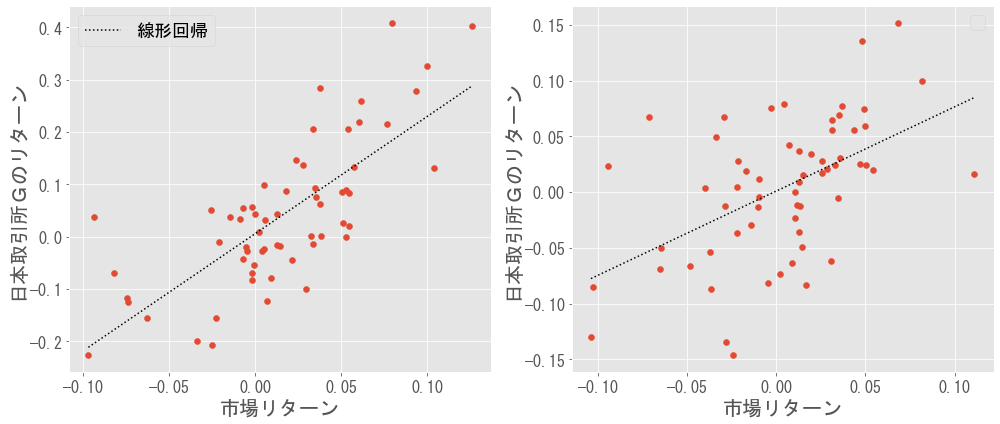

In [25]:
# 個別銘柄の推計
idx = 79

fig = plt.figure(figsize = (14, 6), tight_layout = True)
ax = fig.add_subplot(1, 2, 1)
model_LR_beta.fit(Y_train, X_train) # ハイパーパラメータの初期値もtrainから決める
x_pred_idx = np.linspace(X_train[:, 1].min(), X_train[:, 1].max(), 100) # マーケットポートフォリオの範囲
X_pred_idx = add_const(x_pred_idx)
y_pred_idx = model_LR_beta.W[:, idx].dot(X_pred_idx.T)

# プロット
ax.set_xlabel("市場リターン", size = 20, fontname = "MS Gothic")
ax.set_ylabel(df_universe.iloc[idx]["銘柄名"] + "のリターン", size = 20, fontname = "MS Gothic")
ax.tick_params(labelsize = 16) # 目盛ラベルのサイズ
ax.legend(prop = {"family": "MS Gothic", "size": 18}) # 凡例に日本語を使うため
plt.scatter(X_train[:, 1], Y_train[:, idx])
plt.plot(x_pred_idx, y_pred_idx, "k:", label = "線形回帰")
ax.legend(prop = {"family": "MS Gothic", "size": 18}) # 凡例に日本語を使うため

ax = fig.add_subplot(1, 2, 2)
model_LR_beta.fit(Y_valid, X_valid) # ハイパーパラメータの初期値もtrainから決める
x_pred_idx = np.linspace(X_valid[:, 1].min(), X_valid[:, 1].max(), 100) # マーケットポートフォリオの範囲
X_pred_idx = add_const(x_pred_idx)
y_pred_idx = model_LR_beta.W[:, idx].dot(X_pred_idx.T)

# プロット
ax.set_xlabel("市場リターン", size = 20, fontname = "MS Gothic")
ax.set_ylabel(df_universe.iloc[idx]["銘柄名"] + "のリターン", size = 20, fontname = "MS Gothic")
ax.tick_params(labelsize = 16) # 目盛ラベルのサイズ
ax.legend(prop = {"family": "MS Gothic", "size": 18}) # 凡例に日本語を使うため
plt.scatter(X_valid[:, 1], Y_valid[:, idx])
plt.plot(x_pred_idx, y_pred_idx, "k:", label = "線形回帰")